# Table of Content

# 1. The datasets

### 1.1 Loading the data
### 1.2 Problem description and goal 
### 1.3 Features description 

# 2. Exploratory Data Analysis

### 2.1 A look at the Geographical-related Variables
#### 2.1.1 gps_height, longitude and latitude
#### 2.1.2 basin
#### 2.1.3 subvillage, region, region_code, district_code
#### 2.1.4 lga and ward
#### 2.1.5 Population

### 2.2 A look at the Functionnality-related Variables
#### 2.2.1 amount_tsh	
#### 2.2.2 public_meeting	
#### 2.2.3 scheme_management and scheme_name
#### 2.2.4 extraction_type, extraction_type_group, extraction_type_class
#### 2.2.5 Permit
#### 2.2.6 management and management_group
#### 2.2.7 payment and payment_type
#### 2.2.8 quality_group and water_quality	

### 2.3 A look at the Identification-related Variables

#### 2.3.1 date_recorded and construction_year
#### 2.3.2 funder
#### 2.3.3 Installer
#### 2.3.4 wpt_name and id
#### 2.3.5 num_private
#### 2.3.6 recorded_by
#### 2.3.7 source, source_type, and source_class
#### 2.3.8 waterpoint_type and waterpoint_type_group
 
### 2.4 EDA's main take aways

# 3. First drop of features

### 3.1 The evident columns to drop
#### 3.2 The pairs of similar columns:
#### 3.3 The geographical features to chose


# 4. Feature Engineering and Modeling

### 4.1. Missing Values Handling
#### 4.1.1 Changing the 0s to nulls 
#### 4.1.2 Imputing the nulls
#### 4.1.3Binning Amount_tsh,gps_height & Population
#### 4.1.4 Feature Creation on date

### 4.2 Running the First Model

#### 4.2.1 Hyper parameter tunning

### 4.3 Feature Creation 

### 4.4 Trying a lightGBM model

#### 4.4.1 Hyper parameter tunning

# 5. Trying an ensemble: the VotingClassifier
# 6. Conclusion about the main model
# 7. Extra: A trial with H20's Random Forrest 

# 0. Loading the libraries


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pandas_profiling import ProfileReport
from IPython.display import Image
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from copy import copy
from collections import Counter
from scipy.stats import kruskal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm_notebook
from typing import List
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
import scipy.stats as ss
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import h2o
from h2o.estimators import H2ORandomForestEstimator

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. The datasets

## 1.1 Loading the data
The data is provided into 4 different folders: the training data, their labels, the test data, and a sample submission data.
I load here the training data and merge them with their labels on their id. And I also load the test data:

In [4]:
train_values = pd.read_csv("./Data/training_set_values.csv")
train_labels = pd.read_csv("./Data/training_set_labels.csv")
test = pd.read_csv("./Data/test_set_values.csv")
train = pd.merge(train_values,train_labels, on='id')

## 1.2 Problem description and goal 
The goal here is to try helping the Tanzanian Ministry of Water to predict the operating condition of a waterpoint accross the country. We want to predict which pumps are going to continue working, which ones are going to need repairs and which ones are going to fail. We are thus dealing here with a multiclass classification problem.

## 1.3 Features description 
The dataset contains 40 columns providing information about the waterpoints:

- **amount_tsh** : The total static head (the amount water available to waterpoint)
- **date_recorded** : The date the row was entered
- **funder** : Who funded the well
- **gps_height** : The altitude of the well
- **installer** : The organization that installed the well
- **longitude** and **latitude** : The GPS coordinate
- **wpt_name** : The name of the waterpoint if there is one
- **num_private** : *Description not provided*
- **basin** : The geographic water basin
- **subvillage**, **region**, **lga**, and **ward** : The geographic location
- **region_code** and **district_code** : The coded geographic location (coded)
- **population** : The population around the well
- **public_meeting** : A True/False if there was a meeting
- **recorded_by** : The group entering this row of data
- **scheme_management** : Who operates the waterpoint
- **scheme_name** : Who operates the waterpoint
- **permit** : If the waterpoint is permitted
- **construction_year** : The year the waterpoint was constructed
- **extraction_type**, **extraction_type_group**, and **extraction_type_class** : The kind of extraction the waterpoint uses
- **management**, and **management_group** : How the waterpoint is managed
- **payment**, and **payment_type** : What the water costs
- **water_quality**, and **quality_group** : The quality of the water
- **quantity** and **quantity_group** : The quantity of water
- **source**, **source_type**, and **source_class** : The source of the water
- **waterpoint_type**, and **waterpoint_type_group** : The kind of waterpoint

**Observation:** a first observation from reading these descriptions is that we have various columns representing the same information but at a different granularity level. We might need to consider dropping some of them before modeling later on.

In [5]:
# #this will be removed later on but it is a great way to visualize and understand the data:

# profile = ProfileReport(train, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile

# 2. Exploratory Data Analysis

Because we are dealing with an important number of feature, it helps deviding them into 3 classes that we analyse one at a time. We will first start by trying to understand the target variable. Then we will dive into each class, analyzing the variables, looking at their type, quality (checking for missing values and the way of imputing them) and analyzing which column we could drop.

The classes we defined are as follows:

| Geographical-related Variables | Functionnality-related Variables | Identification-related Variables |
| --- | --- | --- |
| gps_height | amount_tsh | date_recorded |
| longitude | public_meeting | funder |
| latitude | scheme_management | installer |
| basin | scheme_name | wpt_name |
| subvillage | extraction_type | num_private |
| region | extraction_type_group | recorded_by |
| lga | extraction_type_class | construction_year |
| ward | permit | source |
| region_code | management | source_type |
| district_code | management_group | source_class |
| population | payment | waterpoint_type |
|  | payment_type | waterpoint_type_group |
|  | quality_group |  |
|  | water_quality |  |
|  | quantity |  |
|  | quantity_group |  |


So, we first turn at looking at the target variable and try to understand its relation with other features.


## 2.1 A look at the Geographical-related Variables

Before looking at the other variables, it helps looking at how distributed is the target variable. As mentionned above, the labels' dataset has 3 values: 
- **functional** - the waterpoint is operational with no repairs needed
- **functional needs repair** - the waterpoint is operational, but repairs are needed
- **non functional** - the waterpoint is not operational

We can look at how the distribution of these 3 variables look accross our data:

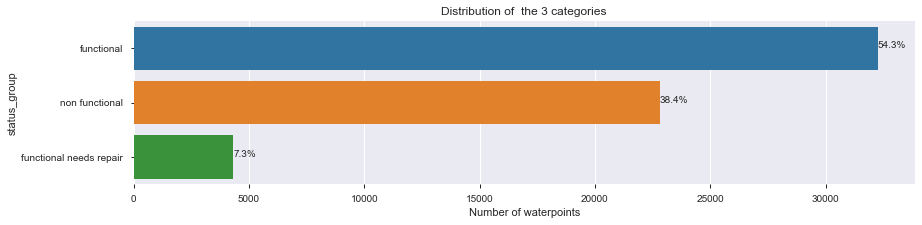

In [6]:
plt.figure(figsize=(14,3))
ax = sns.countplot(y="status_group", data=train)
plt.title('Distribution of  the 3 categories')
plt.xlabel('Number of waterpoints')
total = len(train['status_group'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

**Observation:** 
   - We see that we have the functional category as dominant in our data, with more than half of the waterpoints as functionnal;
   - We have to try finding out if any variable helps explain why waterpoints are functinnal or not.
   
Intuitively, we expect that the location and geographical conditions where the waterpoints are located to be a determining factor in their functionnality. We try support this hypotheses now:

### 2.1.1 gps_height, longitude and latitude
To better understand the region we are dealing with, we decided to map the locations of the waterpoints (we used Ahmed's steps to map explained in https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db):

In [7]:
# We noticed the data contained some 0s for the longitude and latitude so we remove them to plot the remaining on the map
maping= train[train["latitude"] != -2e-08]
maping= train[train["longitude"] != 0]
BBox = ((maping.longitude.min(), maping.longitude.max(), maping.latitude.min(), maping.latitude.max()))

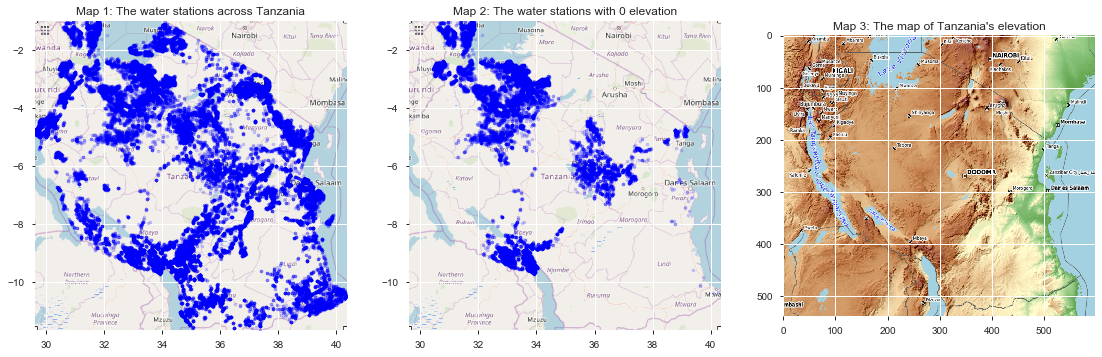

In [8]:
# Maping the locations of the waterpoints
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (19,19))
ruh_m = plt.imread('tanzania_map.png')
ax1.scatter(maping.longitude, maping.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax1.set_title('Map 1: The water stations across Tanzania')
ax1.set_xlim(BBox[0],BBox[1])
ax1.set_ylim(BBox[2],BBox[3])
ax1.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal');
# Maping the locations of the waterpoints with elevation=0
maping2=maping[maping["gps_height"] == 0]
BBox2 = ((maping2.longitude.min(), maping2.longitude.max(), maping2.latitude.min(), maping2.latitude.max()))
ruh_m = plt.imread('tanzania_map.png')
ax2.scatter(maping2.longitude, maping2.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax2.set_title('Map 2: The water stations with 0 elevation')
ax2.set_xlim(BBox[0],BBox[1])
ax2.set_ylim(BBox[2],BBox[3])
ax2.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal');
# Maping the elevation of the country
ruh_m2 = plt.imread('elevation.png')
ax3.set_title("Map 3: The map of Tanzania's elevation")
ax3.imshow(ruh_m2);

**Observations:**

- We can see that the waterpoints are grouped in certain regions, which could be an indication of clustering based on location in later steps;
- We have some waterpoints with latitudes and longitudes equal to 0. This is not possible based on the map of the country as can be seen above. Those values will thus need to be impute in a way in the next section;
- We noticed that we had some waterpoints with elevation of 0. To understand if these elevations are possible values, we looked at those stations in Map 2 and then compared their location with Map 3 which shows elevation across the country. It seems evident that those stations do not have an elevation of 0 and thus will also need to be imputed a value.

### 2.1.2 basin
Tanzania has 9 different basins  that can be seen in the below map. The data for the basins is complete for all the data we have. We thus look next on how the basins' distribution look like when looking at their functionnality. 

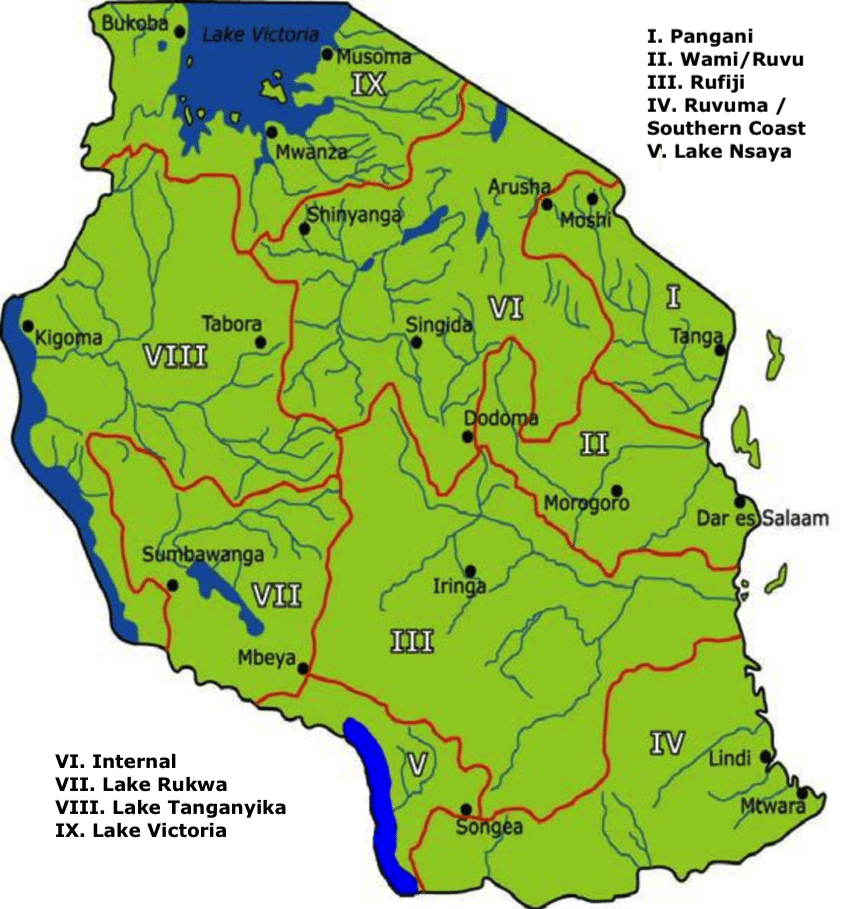

In [9]:
Image (filename = "basins.png", width= 350, height= 350)

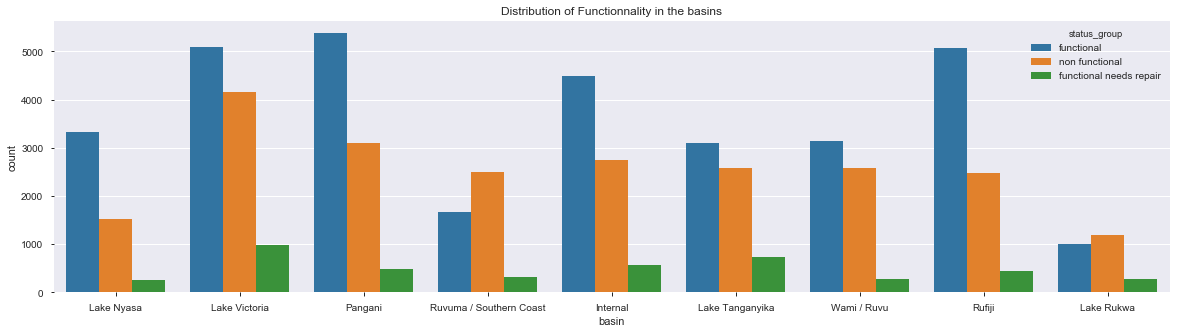

In [10]:
plt.figure(figsize=(20, 5))
sns.countplot(data=train,x='basin',hue='status_group').set_title('Distribution of Functionnality in the basins');

**Observation:**

- We can see that the basins in which the waterpoints are located does influence their functionnality. For instance, the basin of Rufiji seems to have a high ratio of functionnal waterstations, which is the opposite case when looking at Lake Rukwa.
- Given that this variable is complete for all the rows and meaningful, we decide to keep it for further processing later on.

### 2.1.3 subvillage, region, region_code, district_code
These columns seemed to give redundant information. We thus decided to look at their correlations first to see if we could drop any. And then we look at how meaningful these variables are for the problem.
To find the correlation between those categorical variables, we used a function found in this Medium post https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9:

In [11]:
# Function to find the correlation between categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [12]:
print("The correlation between region and region_code is: " + str(cramers_v(train["region"], train["region_code"])))
print("The correlation between district_code and region_code is: " + str(cramers_v(train["district_code"], train["region_code"])))

The correlation between region and region_code is: 0.9980947639844059
The correlation between district_code and region_code is: 0.4191637986775438


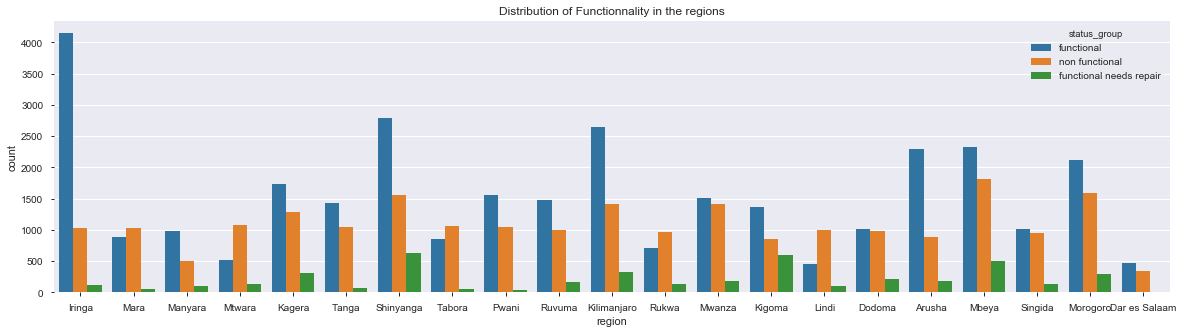

In [13]:
plt.figure(figsize=(20, 5))
sns.countplot(data=train,x='region',hue='status_group').set_title('Distribution of Functionnality in the regions');

In [14]:
print("The number of unique values for the variable subvillage are: " + str(len(train['subvillage'].unique())))

The number of unique values for the variable subvillage are: 19288


**Observations:** 

- Given the very high correlation between region and region_code, it would be logical to drop one of them;
- The subvillage variable has too many levels and thus will most probably be unnecessary and should be removed;
- If judged necessary, in order to reduce dimensionnality, if we consider that the information given by the latitudes and longitudes are enough, we could drop those columns

### 2.1.4 lga and ward

It helps understanding these different division types in Tanzania. Indeed the hierarchy of the divisions are as follows according to Wikipedia:

*The country is divided into thirty-one regions; each region is subdivided into districts. The districts are sub-divided into divisions and further into local wards.*

And the lga variable here means here Locoal Government Authority.



**Observation:**

- We will have to decide on which variables to keep for the location features as they all have similar information but in different granularities.

### 2.1.5 Population

We noticed that a large amount of entries had a population of either 0 or 1. This seemed unlogical to us because building a waterpoint for such little amount of people is probably not what happened. We then thought that maybe these waterpoints were unfunctionnal and thus abandonned by people. So we plotted the following graph to test this hypothesis:

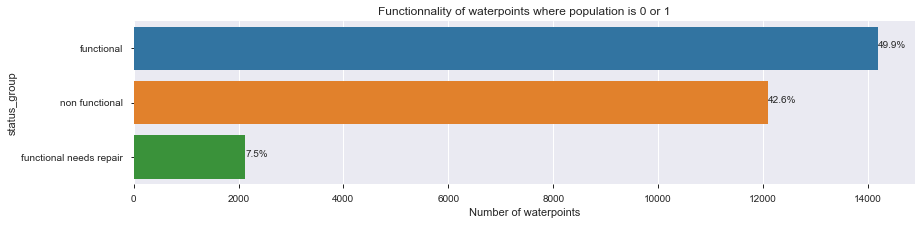

In [15]:
pop_0= train[(train['population']==0) | (train['population']==1) ]
plt.figure(figsize=(14,3))
ax = sns.countplot(y="status_group", data=pop_0)
plt.title('Functionnality of waterpoints where population is 0 or 1')
plt.xlabel('Number of waterpoints')
total = len(pop_0['status_group'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

**Observation:**

- It seems that a population of 0 or 1 does not necessarily implies a non functionnal waterpoint. We will thus need to find a way to impute those values

## 2.2 A look at the Functionnality-related Variables
We can now turn to the second types of variables, looking at those related to functionnality. 

### 2.2.1 amount_tsh	
While analyzing this value, we noticed a similar behaviour as with the altitude and population. Indeed we have a lot of values that were equal to 0 as can be seen below:

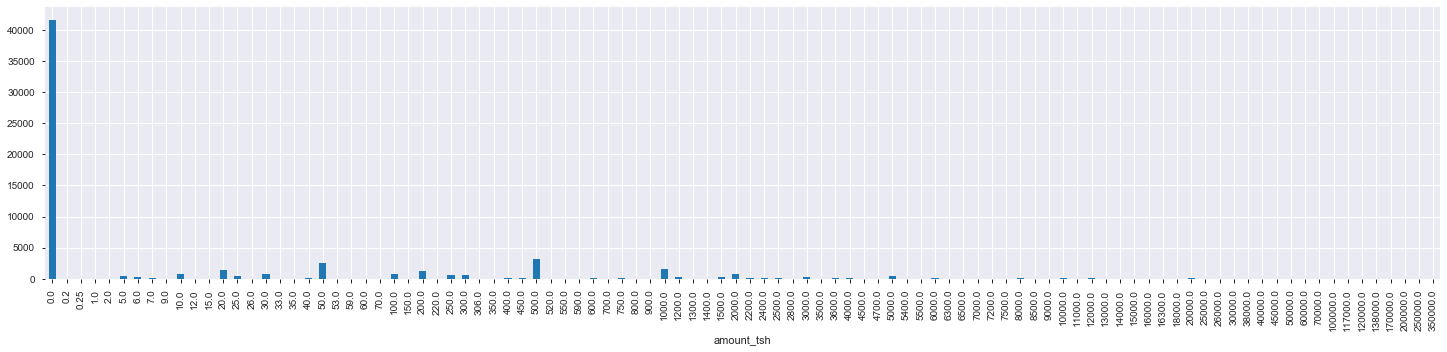

In [16]:
fig, ax = plt.subplots(figsize=(25,5))
train.groupby('amount_tsh').count()['id'].plot(kind="bar",ax=ax);

We thus plotted again the same variable while removing those ones with 0s:

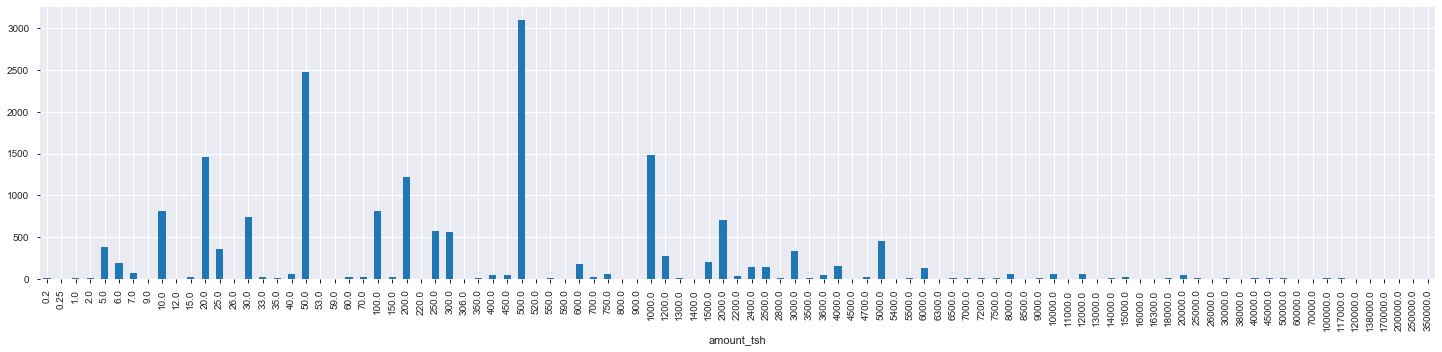

In [17]:
plot1= train[train["amount_tsh"]!=0]
fig, ax = plt.subplots(figsize=(25,5))
plot1.groupby('amount_tsh').count()['id'].plot(kind= "bar",ax=ax);

We thus believe that the 0 values could be missing values instead. To get a feel of wheter this variable could be meaningful in determining if a station is functionnal or not, we plot here the amount_tsh with 0 values removed:

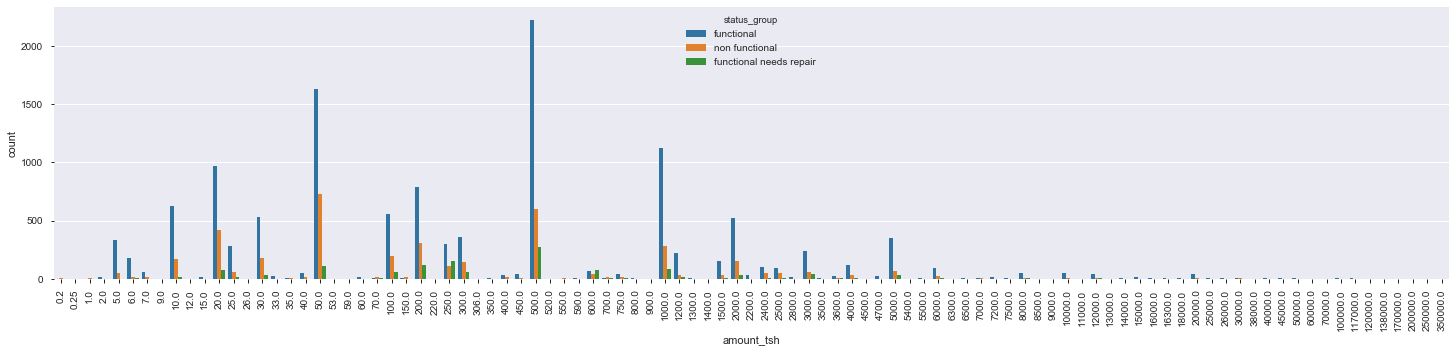

In [18]:
plt.figure(figsize=(25, 5))
chart = sns.countplot(data=plot1,x='amount_tsh',hue='status_group')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

In [19]:
percentage = round(((train["amount_tsh"]==0).sum()/len(train["amount_tsh"]!=0)*100),2)
print("The percentage of rows with 0 in amount_tsh is: " + str(percentage) + "%.")

The percentage of rows with 0 in amount_tsh is: 70.1%.


**Observation:**

- Given that the amount_tsh has a high proportion of 0s (most probably missing values), we could decide to drop the column or impute those values according to other ones.

### 2.2.2 public_meeting	
Does the fact of having a public meeting at the waterstation influence its function later on?

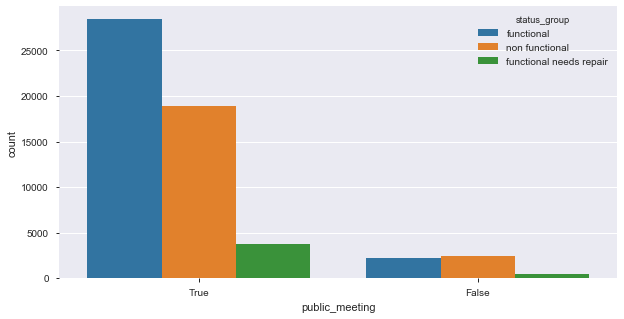

In [20]:
plt.figure(figsize=(10, 5))
chart = sns.countplot(data=train,x='public_meeting',hue='status_group')

In [21]:
percentage_pm=round(train['public_meeting'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in public meeting is: " + str(percentage_pm) + "%")

The percentage of missing values in public meeting is: 5.61%


Most of the rows seem to have a value for whether a public meeting was held or not. And out of those that we have values for, they were distributed as follows:

In [22]:
train['public_meeting'].value_counts(normalize=True)

True     0.909838
False    0.090162
Name: public_meeting, dtype: float64

**Observations:**

- We can see that the majority of waterstations had a meeting. We could thus potentially drop the column as this number is quite high;
- If we decide to keep it, we can impute the missing values as false.

### 2.2.3 scheme_management and scheme_name
As mentionned before, we here have a pair of variables that point to the same information on a different granular level. We thus examine them to see which one we could drop:

In [23]:
print("The correlation between scheme_management and scheme_name is: " + str(cramers_v(train["scheme_management"], train["scheme_name"])))

The correlation between scheme_management and scheme_name is: 0.7861879055767124


In [24]:
len_sm=len(train["scheme_management"].value_counts())
len_sn=len(train["scheme_name"].value_counts())
print("The number of unique values for scheme_management is: "+str(len_sm)+ 
     ". And the number of unique values for scheme_name is: "+ str(len_sn))

The number of unique values for scheme_management is: 12. And the number of unique values for scheme_name is: 2696


In [25]:
percentage_sm=round(train['scheme_management'].isnull().sum()/len(train)*100,2)
percentage_sn=round(train['scheme_name'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in scheme_management is: " + str(percentage_sm) + "%"
     + " and the percentage of missing values in scheme_name is " + str(percentage_sn) + "%")

The percentage of missing values in scheme_management is: 6.53% and the percentage of missing values in scheme_name is 47.42%


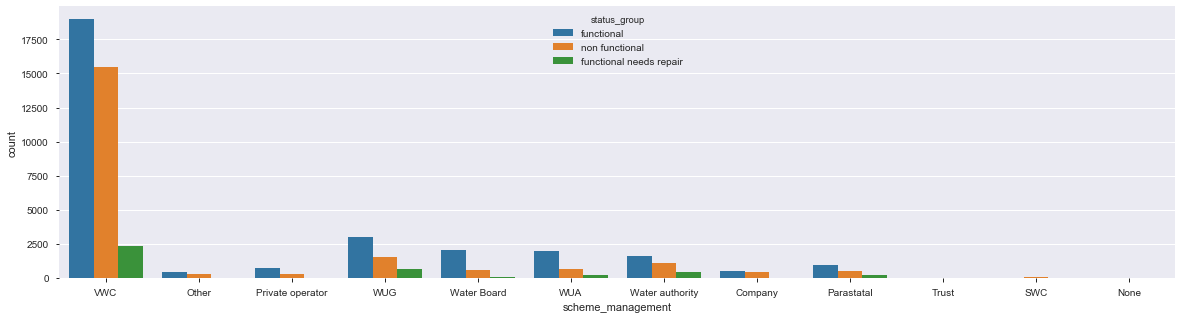

In [26]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(data=train,x='scheme_management',hue='status_group')

**Observation:**

- We see that scheme_name has almost half of its values missing. This is not the case for scheme_management and thus we could decide here to drop scheme_name and keep scheme_management. The missing values could be filled with "Other".

### 2.2.4 extraction_type, extraction_type_group, extraction_type_class

In [27]:
print("The correlation between extraction_type and extraction_type_group is: " + str(cramers_v(train["extraction_type"], train["extraction_type_group"])))
print("The correlation between extraction_type and extraction_type_class is: " + str(cramers_v(train["extraction_type"], train["extraction_type_class"])))
print("The correlation between extraction_type_group and extraction_type_class is: " + str(cramers_v(train["extraction_type_group"], train["extraction_type_class"])))

The correlation between extraction_type and extraction_type_group is: 0.9999579023587122
The correlation between extraction_type and extraction_type_class is: 0.9999073922064348
The correlation between extraction_type_group and extraction_type_class is: 0.9999494877212747


We see that those 3 variables are highly correlated. Let's look then at their count by group:

In [28]:
train.groupby(['extraction_type_group','extraction_type_class','extraction_type']).size().to_frame('count')

count
extraction_type_group extraction_type_class extraction_type                 
afridev               handpump              afridev                     1770
gravity               gravity               gravity                    26780
india mark ii         handpump              india mark ii               2400
india mark iii        handpump              india mark iii                98
mono                  motorpump             mono                        2865
nira/tanira           handpump              nira/tanira                 8154
other                 other                 other                       6430
other handpump        handpump              other - mkulima/shinyanga      2
                                            other - play pump             85
                                            other - swn 81               229
                                            walimi                        48
other motorpump       motorpump             cemo                          90
                                            climax                        32
rope pump             rope pump             other - rope pump            451
submersible           submersible           ksb                         1415
                                            submersible                 4764
swn 80                handpump              swn 80                      3670
wind-powered          wind-powered          windmill                     117

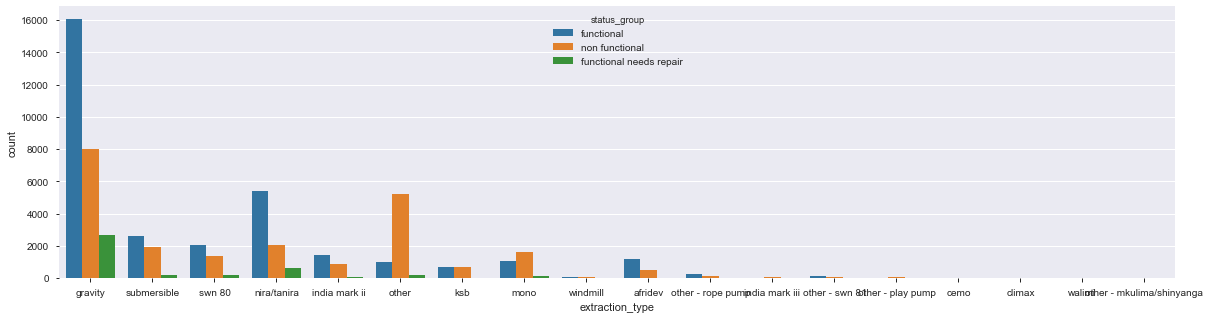

In [29]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(data=train,x='extraction_type',hue='status_group')

**Observation:**

- We can conclude that it would be reasonnable to drop at least one of these columns. And maybe for the values in some of them with minimal amounts like "other-mkulima/shinyanga" with only 2 occurences, to group those.

### 2.2.5 Permit
As with public_meeting, this is a boolean variable. We see if it has null values and their proportion:

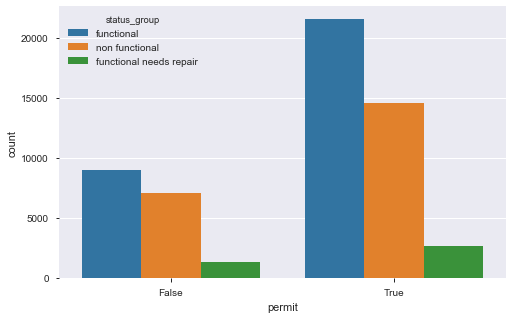

In [30]:
plt.figure(figsize=(8, 5))
chart = sns.countplot(data=train,x='permit',hue='status_group')

In [31]:
percentage_pe=round(train['permit'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in permit is: " + str(percentage_pe) + "%")

The percentage of missing values in permit is: 5.14%


Most of the rows seem to have a value for whether a permit was held or not. And out of those that we have values for, they were distributed as follows:

In [32]:
train['permit'].value_counts(normalize=True)

True     0.68955
False    0.31045
Name: permit, dtype: float64

**Observation:**

- Like the public_meeting, we have only 5% of missing values. This variable seems a bit more informative with a 70-30 ratio of True/False;
- Again here, we could impute the missing values as False.

### 2.2.6 management and management_group
Again here we have a pair of values with different granularity but similar information. We analyse it in the same way as above

In [33]:
print("The correlation between management and management_group is: " + str(cramers_v(train["management"], train["management_group"])))

The correlation between management and management_group is: 0.9999410707445201


We can now take a look at what the management category is grouped into:

In [34]:
train.groupby(['management_group','management']).size().to_frame('count')

count
management_group management             
commercial       company             685
                 private operator   1971
                 trust                78
                 water authority     904
other            other               844
                 other - school       99
parastatal       parastatal         1768
unknown          unknown             561
user-group       vwc               40507
                 water board        2933
                 wua                2535
                 wug                6515

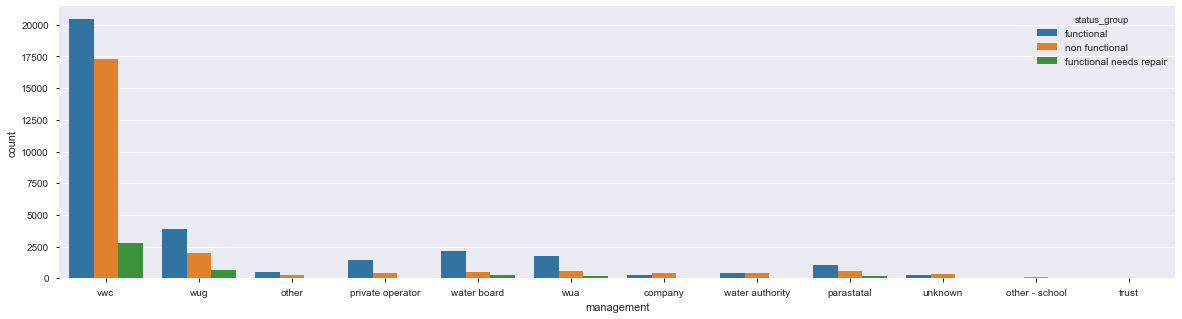

In [35]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(data=train,x='management',hue='status_group')

We see that one group, VWC dominate the management of the waterpoints. Note that it is the same company that dominate in the variable management_scheme.

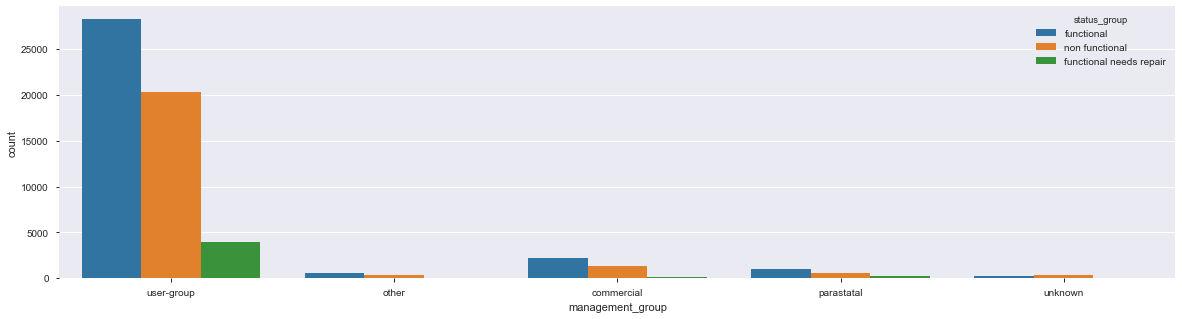

In [36]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(data=train,x='management_group',hue='status_group')

In [37]:
percentage_ma=round(train['management'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in management is: " + str(percentage_ma) + "%")
percentage_mag=round(train['management_group'].isnull().sum()/len(train)*100,2)
print("And the percentage of missing values in management_group is: " + str(percentage_pe) + "%")

The percentage of missing values in management is: 0.0%
And the percentage of missing values in management_group is: 5.14%


**Observations:**

- Here we could keep management for the greater details it has. And we do not need to worry about null values for these variables.

### 2.2.7 payment and payment_type
Another related pair of variables, we look at them in the same way we did for the other cases:

In [38]:
print("The correlation between payment and payment_type is: " + str(cramers_v(train["payment"], train["payment_type"])))

The correlation between payment and payment_type is: 1.0


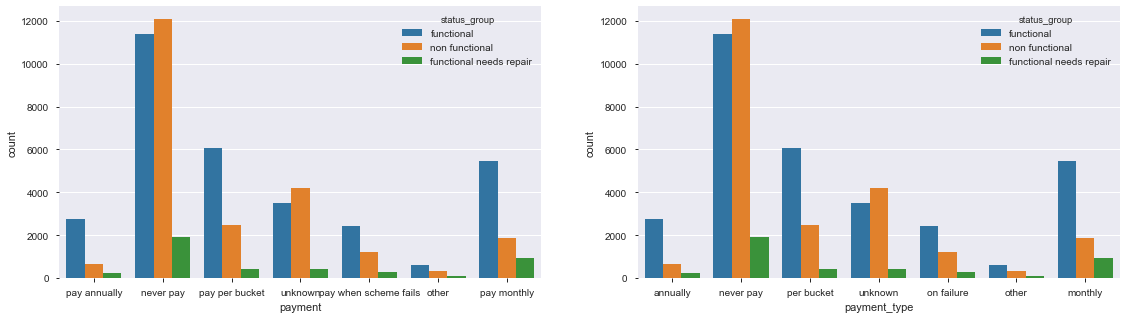

In [39]:
fig, ax =plt.subplots(1,2, figsize=(19,5))
sns.countplot(data=train,x='payment',hue='status_group', ax=ax[0])
sns.countplot(data=train,x='payment_type',hue='status_group', ax=ax[1]);

The two variables seem to be identical. We can verify this by looking at the following table:

In [40]:
percentage_pay=round(train['payment'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in payment is: " + str(percentage_pay) + "%")
percentage_pt=round(train['payment_type'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in payment_type is: " + str(percentage_pt) + "%")

The percentage of missing values in payment is: 0.0%
The percentage of missing values in payment_type is: 0.0%


**Observations:**

- Those two columns are the same with different value names and both do not have missing values. We will thus have to keep one only.

### 2.2.8 quality_group and water_quality	
We follow the flow used earlier to analyse pair vaariables:

In [41]:
print("The correlation between quality_group and water_quality is: " + str(cramers_v(train["quality_group"], train["water_quality"])))


The correlation between quality_group and water_quality is: 0.9999831631407465


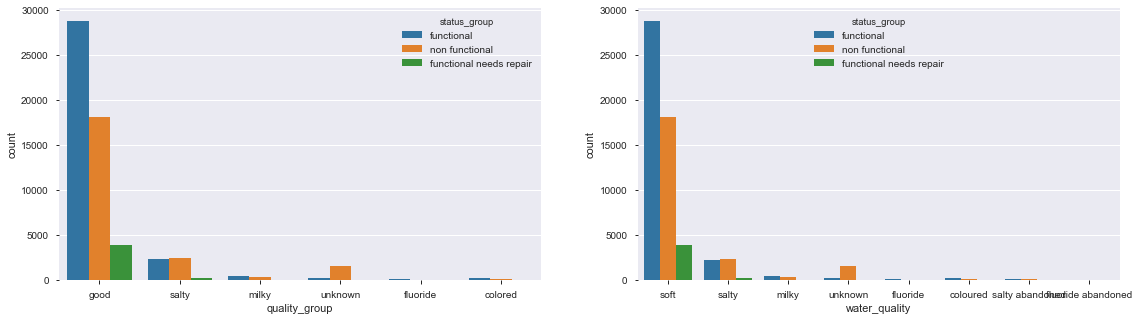

In [42]:
fig, ax =plt.subplots(1,2, figsize=(19,5))
sns.countplot(data=train,x='quality_group',hue='status_group', ax=ax[0])
sns.countplot(data=train,x='water_quality',hue='status_group', ax=ax[1]);

With almost a correlation of 100%, and very similar distributions.
We can look at the different values in each feature:

In [43]:
train.groupby(['quality_group','water_quality']).size().to_frame('count')

count
quality_group water_quality            
colored       coloured              490
fluoride      fluoride              200
              fluoride abandoned     17
good          soft                50818
milky         milky                 804
salty         salty                4856
              salty abandoned       339
unknown       unknown              1876

In [44]:
percentage_qua=round(train['quality_group'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in quality_group is: " + str(percentage_qua) + "%")
percentage_wqua=round(train['water_quality'].isnull().sum()/len(train)*100,2)
print("The percentage of missing values in water_quality is: " + str(percentage_wqua) + "%")

The percentage of missing values in quality_group is: 0.0%
The percentage of missing values in water_quality is: 0.0%


**Observations:** 

- We see that keeping water_quality would make more sense here.

### 2.2.8 quantity_group and quantity
We look at those two variables in a similar way:

In [45]:
print("The correlation between quantity_group and quantity is: " + str(cramers_v(train["quantity"], train["quantity_group"])))

The correlation between quantity_group and quantity is: 1.0


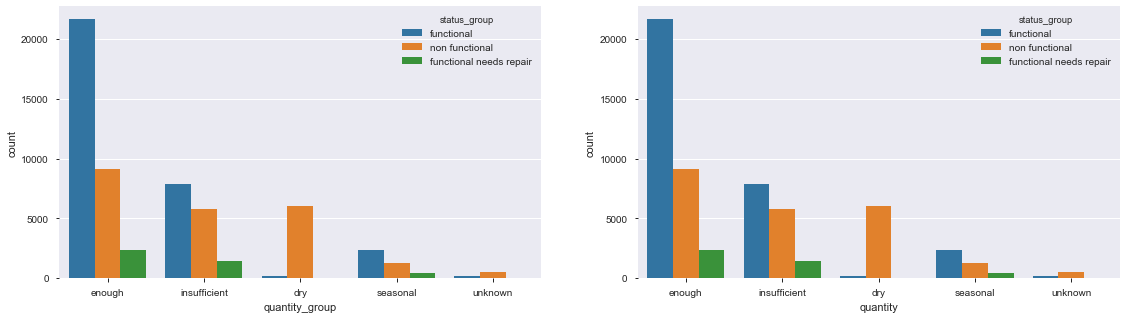

In [46]:
fig, ax =plt.subplots(1,2, figsize=(19,5))
sns.countplot(data=train,x='quantity_group',hue='status_group', ax=ax[0])
sns.countplot(data=train,x='quantity',hue='status_group', ax=ax[1]);

In [47]:
print("The values in quantity and in quantity_group are similar in " + 
      str((train["quantity_group"] == train["quantity"]).sum()/len(train)*100) + "% of the rows.")

The values in quantity and in quantity_group are similar in 100.0% of the rows.


**Observation:**

- These two variables are exactly similar. Thus removing one one them will be necessary. 
- Another interesting insight to keep in mind is that most functionnal waterstations have enough water and those who have a dried quantity are mostly non functionnal.

## 2.3 A look at the Identification-related Variables
We now look at the last class of variables, the one related to identifying the waterstations.

### 2.3.1 date_recorded and construction_year
We start by looking at the date_recorded and construction_year, which indicates when the entry was made and when the water station was built respectively.
We noticed that the column was not a datetime object, we thus chane its type before analyzing it. And we also add additional variables to try finding additionnal insights:

In [48]:
time=train.copy()
time["date_recorded"] = pd.to_datetime(train["date_recorded"])
time["year_reco"] = time["date_recorded"].map(lambda x: x.year)
time["month_reco"] = time["date_recorded"].map(lambda x: x.month)
time["day_reco"] = time["date_recorded"].map(lambda x: x.day)

We could start by looking at the distribution of each:

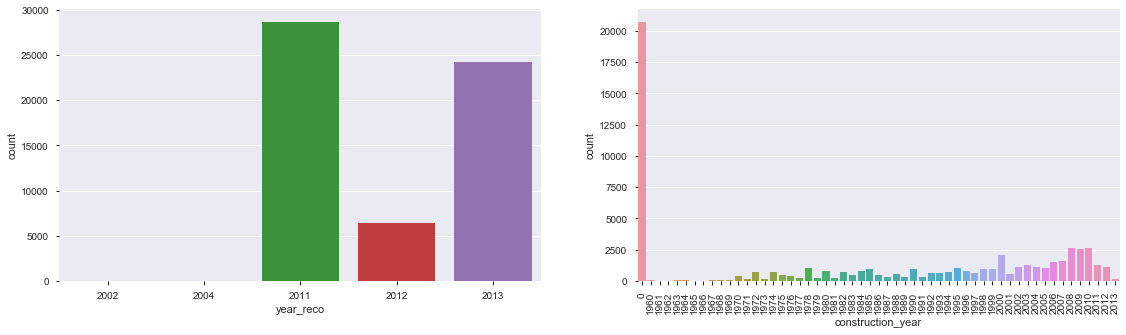

In [49]:
fig, ax =plt.subplots(1,2, figsize=(19,5))
chart1=sns.countplot(data=time,x='year_reco', ax=ax[0])
chart2=sns.countplot(data=time,x='construction_year', ax=ax[1])
plt.xticks(rotation=90);

So most of the recorded rows were between 2011 and 2013. Another flagrant observation is that we have a high concentration of 0s in construction_year. So we need to find a way to impute them later on. Looking at the construction_year against functionnality gives the following:

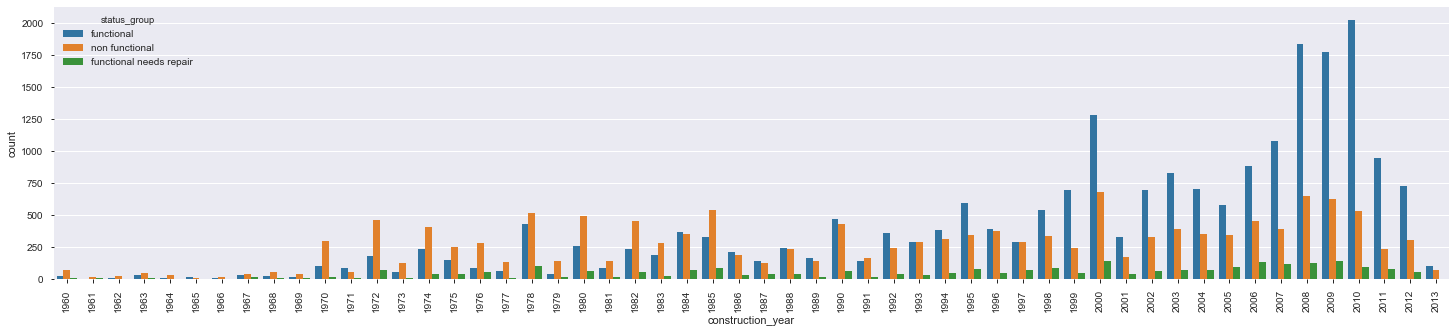

In [50]:
cy = time[time['construction_year']!=0]
plt.figure(figsize=(25,5))
chart = sns.countplot(data= cy,x='construction_year',hue='status_group')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

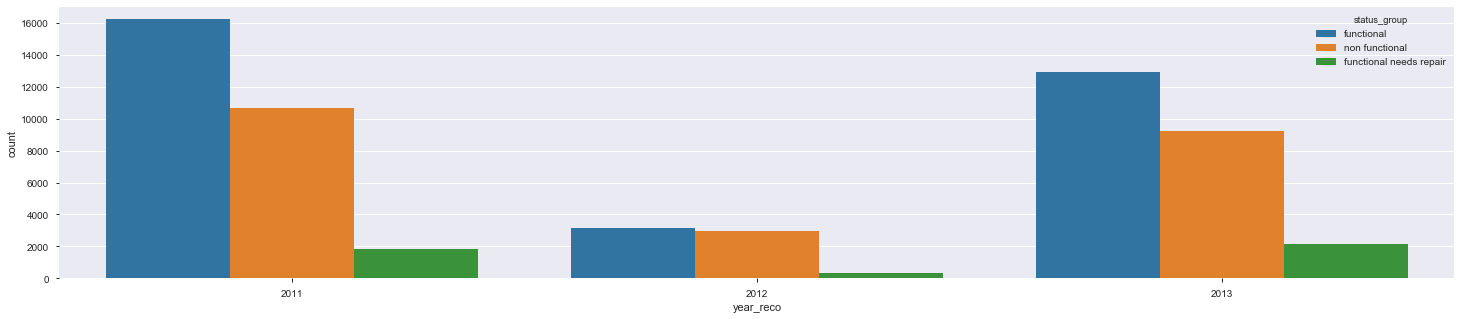

In [51]:
year= time[(time["year_reco"]==2011) | (time["year_reco"]==2012)| (time["year_reco"]==2013)]
plt.figure(figsize=(25, 5))
sns.countplot(data=year,x='year_reco',hue='status_group');

In [52]:
percentage_dat=round(time['date_recorded'].isnull().sum()/len(time)*100,2)
print("The percentage of missing values in date_recorded is: " + str(percentage_dat) + "%")
percentage_yc=round(time['construction_year'].isnull().sum()/len(time)*100,2)
print("The percentage of missing values in constructin_year is: " + str(percentage_yc) + "%")

The percentage of missing values in date_recorded is: 0.0%
The percentage of missing values in constructin_year is: 0.0%


**Observations:**

- Almost all the information in date_recorded are from 2011 until 2013 (with very minimal entries in 2004 and 2002);
- We could maybe combine those 2 variables and derive for example a column called operational_for that would be the difference of these 2 columns;
- Through the histogram we can see that as the closer we get to the present the larger number of functional wells we have compared to non fuctional;
- There are 0 values input instead of nulls for the years, therefore these variables need to be changed.

### 2.3.2 funder
Let's take a look at how many different funders we have in the dataset:

In [53]:
print("The funder variable has " + str(len(train.funder.unique())) + " unique values.")

The funder variable has 1898 unique values.


In [54]:
percentage_fu=round(time['funder'].isnull().sum()/len(time)*100,2)
print("The percentage of missing values in funder is: " + str(percentage_fu) + "%")

The percentage of missing values in funder is: 6.12%


To try having a feel on whether the funder has an influence on the functionnality we look at the top 10 funders:

In [55]:
train["funder"].value_counts().to_frame("count").head(10)

,count
Government Of Tanzania,9084
Danida,3114
Hesawa,2202
Rwssp,1374
World Bank,1349
Kkkt,1287
World Vision,1246
Unicef,1057
Tasaf,877
District Council,843


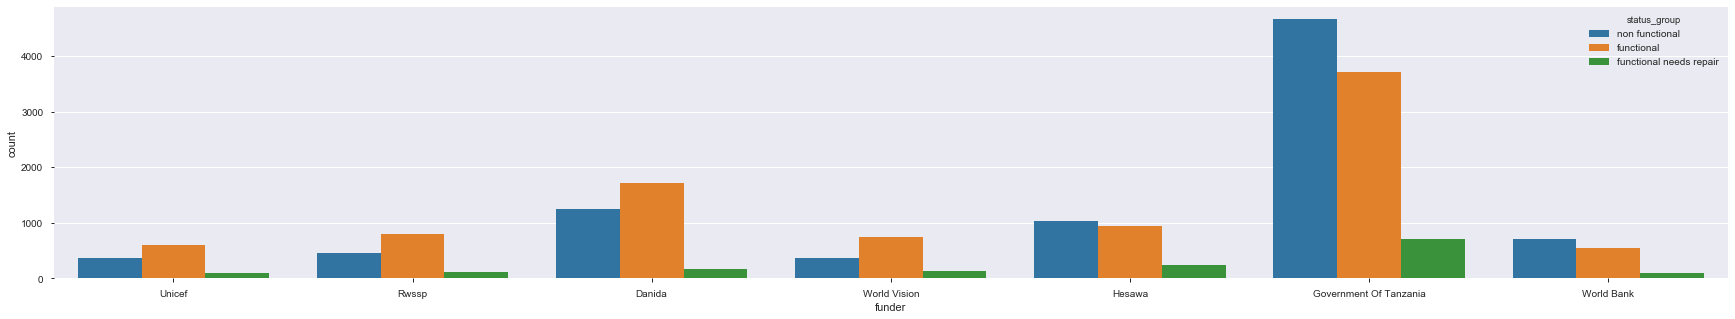

In [56]:
fund= train[(train["funder"]=="Government Of Tanzania") | (train["funder"]=="Danida")| (train["funder"]=="Hesawa") |
             (train["funder"]=="Rwssp") | (train["funder"]=="World Bank")|(train["funder"]=="KKKT")
             | (train["funder"]=="World Vision") |(train["funder"]=="Unicef") |(train["funder"]=="TCTasaf") ]
plt.figure(figsize=(30, 5))
sns.countplot(data=fund,x='funder',hue='status_group');

**Observations:**

- We have null values and a value name "0" in the feature. 
- We could create a category called "Others" and put all the ones below a treshold as we have nearly 1900 distinct values

### 2.3.3 Installer
Let's take a look at how many different installers we have in the dataset and if they are related to funders:

In [57]:
print("The correlation between installer and funder is: " + str(cramers_v(train["installer"], train["funder"])))

The correlation between installer and funder is: 0.7528673513680268


In [58]:
print("The installer variable has " + str(len(train.installer.unique())) + " unique values.")

The installer variable has 2146 unique values.


In [59]:
percentage_in=round(time['installer'].isnull().sum()/len(time)*100,2)
print("The percentage of missing values in installer is: " + str(percentage_in) + "%")

The percentage of missing values in installer is: 6.15%


In [60]:
train["installer"].value_counts().to_frame("count").head(10)

,count
DWE,17402
Government,1825
RWE,1206
Commu,1060
DANIDA,1050
KKKT,898
Hesawa,840
0,777
TCRS,707
Central government,622


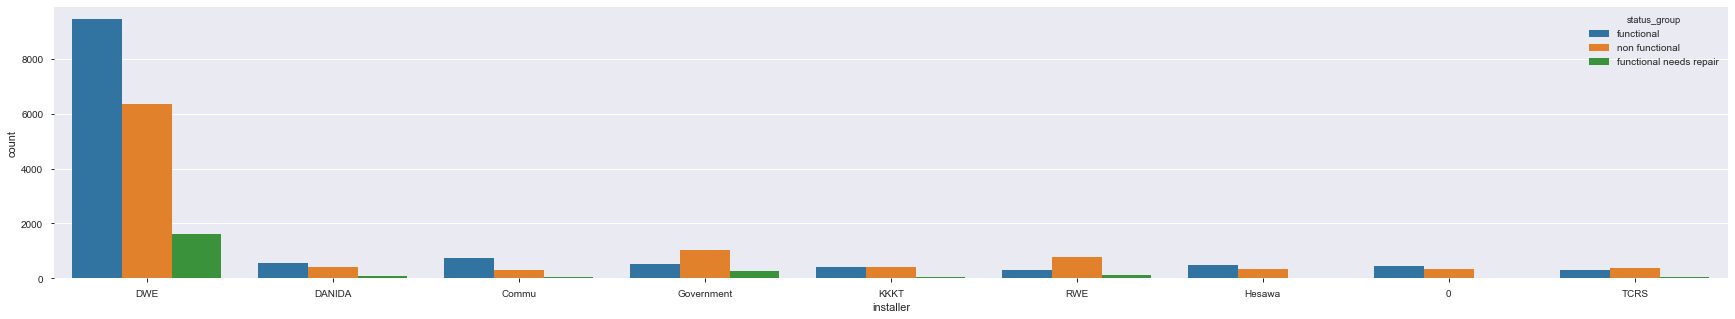

In [61]:
inst= train[(train["installer"]=="DWE") | (train["installer"]=="Government")| (train["installer"]=="RWE") |
             (train["installer"]=="Commu") | (train["installer"]=="DANIDA")|(train["installer"]=="KKKT")
             | (train["installer"]=="Hesawa") |(train["installer"]=="0") |(train["installer"]=="TCRS") ]
plt.figure(figsize=(30, 5))
sns.countplot(data=inst,x='installer',hue='status_group');

 **Observations:**
 
 - We notice that we have many funders that are also installers. We may want to look at this later on like for instance looking at if we have a relationship between funder-installer and functionnability of the waterpoint;
 - The DWE (Department of Water Engineer) is the one responsible for the most installations;
 - We have null values and a value name "0" in the feature and we could create a category called "Others" and put all the ones below a treshold as we have nearly 1900 distinct values

### 2.3.4 wpt_name and id
We do not expect the name of the waterpoint to be of a significance in determining the functionnability of the waterstations, but we take a broad look at it to make sure:

In [62]:
print("The wpt_name variable has " + str(len(train.wpt_name.unique())) + " unique values.")

The wpt_name variable has 37400 unique values.


In [63]:
percentage_wt=round(time['wpt_name'].isnull().sum()/len(time)*100,2)
print("The percentage of missing values in wpt_name is: " + str(percentage_wt) + "%")

The percentage of missing values in wpt_name is: 0.0%


**Observation:**

- We will most probably drop this variable as it is not very informative with so many distinct values;
- The same holds for the id column.

### 2.3.5 num_private
We do not have any description for this variable, but we can try to see if it is useful:

In [64]:
train["num_private"].value_counts()[:5]

0    58643
6       81
1       73
5       46
8       46
Name: num_private, dtype: int64

In [65]:
print("The number of 0s in this column are equal to " + str((train["num_private"]==0).sum()/len(train)*100) + "%.")

The number of 0s in this column are equal to 98.72558922558923%.


**Observation:**

- We could try to see if we transform this variable into a boolean one if it adds something, or we could consider dropping it.

### 2.3.6 recorded_by
Let's take a look at this feature:

In [66]:
train["recorded_by"].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [67]:
percentage_rb=round(time['recorded_by'].isnull().sum()/len(time)*100,2)
print("The percentage of missing values in recorded_by is: " + str(percentage_rb) + "%")

The percentage of missing values in recorded_by is: 0.0%


**Observation:**

- We have one constant variable here, with all the rows recorded by the same entity, this column can thus be dropped.

### 2.3.7 source, source_type, and source_class
We now look at the source type of the waterstation:

In [68]:
print("The correlation between source and source_class is: " + str(cramers_v(train["source"], train["source_class"])))
print("The correlation between source and source_type is: " + str(cramers_v(train["source"], train["source_type"])))
print("The correlation between source_type and source_class is: " + str(cramers_v(train["source_type"], train["source_class"])))

The correlation between source and source_class is: 0.9999410727288286
The correlation between source and source_type is: 0.9999747441795817
The correlation between source_type and source_class is: 0.9999663276988254


In [69]:
train.groupby(['source_class','source_type','source']).size().to_frame('count')

count
source_class source_type          source                     
groundwater  borehole             hand dtw                874
                                  machine dbh           11075
             shallow well         shallow well          16824
             spring               spring                17021
surface      dam                  dam                     656
             rainwater harvesting rainwater harvesting   2295
             river/lake           lake                    765
                                  river                  9612
unknown      other                other                   212
                                  unknown                  66

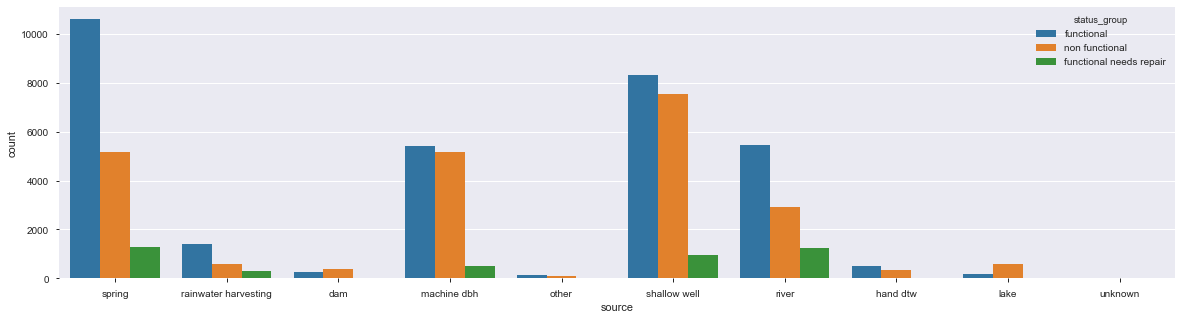

In [70]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(data=train,x='source',hue='status_group')

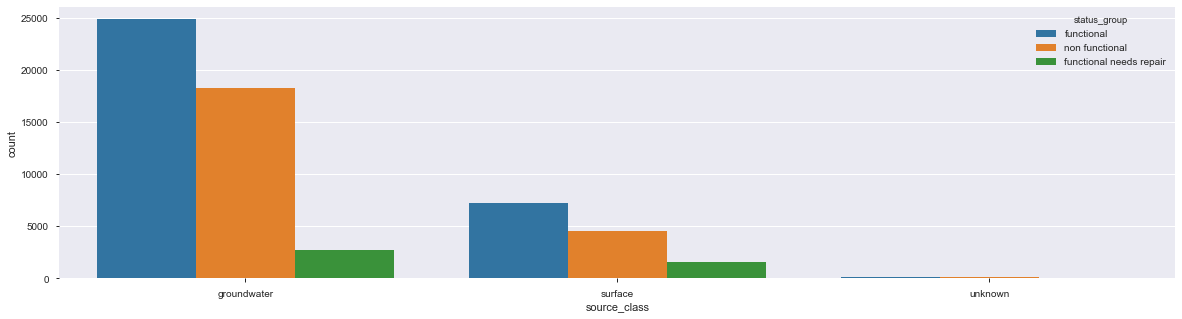

In [71]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(data=train,x='source_class',hue='status_group')

**Observations:**
- Source_type and source are almost identical, and source_class seems to be a larger category of these, therefore at least one of these columns could be dropped;
- Springs are the most reliable source type.

### 2.3.8 waterpoint_type and waterpoint_type_group
Lastly we take a look at those 2 last features:

In [72]:
print("The correlation between waterpoint_type and waterpoint_type_group is: " + str(cramers_v(train["waterpoint_type"], train["waterpoint_type_group"])))

The correlation between waterpoint_type and waterpoint_type_group is: 0.9999915816058086


In [73]:
train.groupby(['waterpoint_type_group','waterpoint_type']).size().to_frame('count')

count
waterpoint_type_group waterpoint_type                   
cattle trough         cattle trough                  116
communal standpipe    communal standpipe           28522
                      communal standpipe multiple   6103
dam                   dam                              7
hand pump             hand pump                    17488
improved spring       improved spring                784
other                 other                         6380

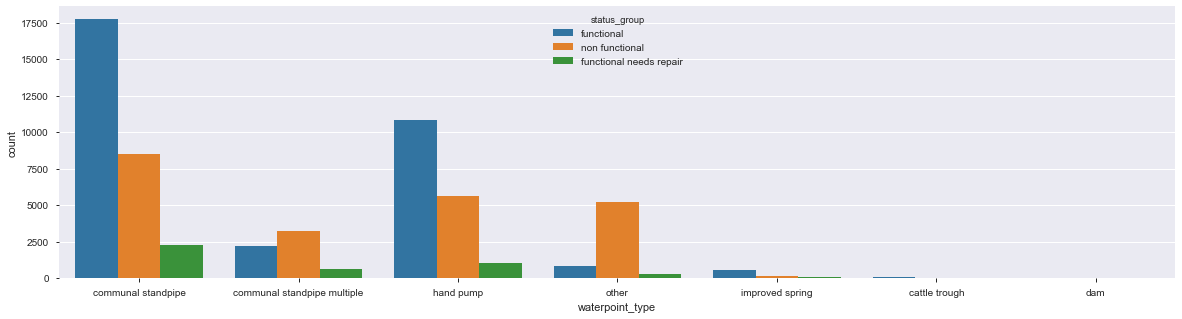

In [74]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(data=train,x='waterpoint_type',hue='status_group')

**Observations:**
    
- These two columns are identical and one can be dropped.
- Communal standpipe is the most common water point and most functional.

## 2.4 EDA's main take aways

Out of the 40 variables, the EDA showed that we could get rid of many of them due to almost 100% correlation or because they were constant variables. This section also allowed us to see that we have many variables with missing values that we need to define a strategy to impute. Finally this section also showed the relationship between the variables and the target variable and helped get a better understanding of the data on hand and the problem itself. The actions taken based on the EDA follow in the next section.


# 3. First drop of features

## 3.1 The evident columns to drop

So the columns that should obviously be dropped are the following seven:

- **id**: As seen, it does not help in predicting the target variable
- **recorded_by**: We saw that it was a constant value in all the rows
- **num_private**: We do not know what this describes and more than 99% 0s
- **subvillage**: We have too many subvillages, and this will not add a lot of information
- **wpt_name**: Same reason as above, with more than 30.000 different names, it is non useful.
- **scheme_name**: Also a variable with more than 2500 different values. 
- **payment**: This feature contains the same information as payment_type so keeping one only makes sense.
- **quantity_group**: It has the same values as quantity



## 3.2 The pairs of similar columns:

For the pair of similar values, we dropped the following six:

- **management_group**: Because management has a greater level of details and no missing values.
- **waterpoint_type_group**: Because waterpoint_type has one more level of detail.
- **quality_group**: Because water_quality has two more levels of detail.
- **extraction_type_group**, and **extraction_type_class**: Because extraction_type has the most adequate level of information
- **source_type**: Because source has a better level of details and source_class has only 3 classes that could be informative.


## 3.3 The geographical features to chose

We decided for the geographical-related columns to drop: 
- **region_code**: Because we would keep the feature region
- **distrcit_code**, **lga**, and **ward**: Because we believe that keeping the latitude, longitude, region, and basins are enough for the geographical information needed.

But note that before dropping them, we will use some in the following section to impute some missing values.

So in total, we identified 18 columns we could drop, which are the following:

In [75]:
droping = ["id","recorded_by", "num_private", "subvillage", "wpt_name", "scheme_name", "payment", "quantity_group",
          "management_group", "waterpoint_type_group", "quality_group", "extraction_type_group", "extraction_type_class",
          "source_type", "region_code", "district_code", "lga", "ward", "date_recorded"]

In [76]:
keeping = ['amount_tsh','basin','construction_year','extraction_type','funder','gps_height','installer','latitude',
            'longitude','management','payment_type','permit','population','public_meeting','quantity','region',
            'scheme_management','source','source_class','water_quality','waterpoint_type']

In [77]:
# def difference_list(ar1,ar2,assume_unique=False):
#     ans = np.setdiff1d(ar1,ar2,assume_unique).tolist()
#     if assume_unique:
#         return sorted(ans)
#     return ans

# all_values = list(train_values)
# keeping=difference_list(all_values,droping)
# trainb=train[keeping]

# 4. Feature Engineering and Modeling

## 4.1. Missing Values Handling

As seen throughout the EDA, many features have missing values, we come up with a way of imputing them here.

### 4.1.1 Changing the 0s to nulls 
Before getting to the imputation, we have to fix the six columns in which we noticed we had 0s that were nulls in the EDA (the 0s in lattitude are entered as '-2.000000e-08'). These are:

In [78]:
#Before transforming the data we append the train value and test data to transform all the data together. 
total = train_values.append(test, ignore_index=True) 
total.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [79]:
total["latitude"].replace(-2.000000e-08, np.nan, inplace=True)
total["longitude"].replace(0.0, np.nan, inplace=True)
total["gps_height"].replace(0.0, np.nan, inplace=True)
total["installer"].replace("0", np.nan, inplace=True)
total["funder"].replace("0", np.nan, inplace=True)
total["population"].replace(0.0, np.nan, inplace=True)
total["population"].replace(1.0, np.nan, inplace=True)
total["construction_year"].replace(0.0, np.nan, inplace=True)
total["amount_tsh"].replace(0.0, np.nan, inplace=True)

### 5.1.2 Imputing the nulls

We here start with a straightforward way of imputing variables and we might reconsider some approaches later on to improve our models' performances.

After changing them we can see now which columns we need to focus on:

In [80]:
total[keeping].isnull().sum()[(total[keeping].isnull().sum())!=0]

amount_tsh           52049
construction_year    25969
funder                5484
gps_height           25649
installer             5512
latitude              2269
longitude             2269
permit                3793
population           35616
public_meeting        4155
scheme_management     4846
dtype: int64

For the height, latitude and longitude, we decided to fill the nulls with the mean of each district, this would allow us to have a better estimate:

In [81]:
total["longitude"].fillna(total.groupby('district_code')["longitude"].transform("mean"), inplace=True)
total["latitude"].fillna(total.groupby('district_code')["latitude"].transform("mean"), inplace=True)
total["gps_height"].fillna(total.groupby('district_code')["gps_height"].transform("mean"), inplace=True)
total["gps_height"].fillna(total.groupby('region')["gps_height"].transform("mean"), inplace=True)

Given that amount_tsh has many missing values, here the mean would not be a very good idea, we thus impute the median:

In [82]:
total["amount_tsh"].fillna(total.groupby('district_code')["amount_tsh"].transform("median"), inplace=True)
total["amount_tsh"].fillna(total.groupby('region')["amount_tsh"].transform("median"), inplace=True)

We do the same for construction_year:

In [83]:
total["construction_year"].fillna(total.groupby('district_code')["construction_year"].transform("median"), inplace=True)
total["construction_year"].fillna(total.groupby('region')["construction_year"].transform("median"), inplace=True)

As we saw in the EDA, installer and funder have a lot of different values. Thus the best way to fill those nulls would be to place them in the category "Other" while keeping the categories with the most counts:

In [84]:
# We first put everything in lower case to make sure random capitals don't affect the categorization:
total["funder"] = total.funder.str.lower()
# We then create a function to use 
def funder_cat(row):  
    if row['funder']=='danida':
        return 'danida'
    elif row['funder']=='hesawa':
        return 'hesawa'
    elif row['funder']=='rwssp':
        return 'rwssp'
    elif row['funder']=='world bank':
        return 'world_bank'
    elif row['funder']=='kkkt':
        return 'kkkt'
    elif row['funder']=='world vision':
        return 'world_vision'
    elif row['funder']=='unicef':
        return 'unicef'
    elif row['funder']=='tasaf':
        return 'tasaf'
    elif row['funder']=='district council':
        return 'district_council'
    elif row['funder']=='dhv':
        return 'dhv'
    elif row['funder']=='private individual':
        return 'private_individual'
    elif row['funder']=='dwsp':
        return 'dwsp'
    elif row['funder']=='norad':
        return 'norad'
    else:
        return 'other'
    
total['funder'] = total.apply(funder_cat, axis=1)

In [85]:
total['installer'] = total.installer.str.lower()
total['installer'].value_counts()

def installer_cat(row):  
    if row['installer']=='dwe':
        return 'dwe'
    elif row['installer']=='government':
        return 'government'
    elif row['installer']=='hesawa':
        return 'hesawa'
    elif row['installer']=='rwe':
        return 'rwe'
    elif row['installer']=='commu':
        return 'commu'
    elif row['installer']=='danida':
        return 'danida'
    elif row['installer']=='district council':
        return 'district_council'
    elif row['installer']=='kkkt':
        return 'kkkt'
    elif row['installer']=='central government':
        return 'central_government'
    elif row['installer']=='tcrs':
        return 'tcrs'
    elif row['installer']=='world vision':
        return 'world_vision'
    elif row['installer']=='danid':
        return 'danid'
    else:
        return 'other'
total['installer'] = total.apply(installer_cat, axis=1)

For scheme_management, we do the same:

In [86]:
def manasc_cat(row):  
    if row['scheme_management']=='VWC':
        return 'VWC'
    elif row['scheme_management']=='WUG':
        return 'WUG'
    elif row['scheme_management']=='Water authority':
        return 'Water_authority'
    elif row['scheme_management']=='WUA':
        return 'WUA'
    elif row['scheme_management']=='Water Board':
        return 'Water_Board'
    elif row['scheme_management']=='Parastatal':
        return 'Parastatal'
    elif row['scheme_management']=='Private operator':
        return 'Private_operator'
    elif row['scheme_management']=='Company':
        return 'Company'
    elif row['scheme_management']=='Other' or row['scheme_management']=='SWC' or row['scheme_management']=='None' or row['scheme_management']=='Trust':
        return 'Other'
    else:
        return 'Other'
    
total['scheme_management'] = total.apply(manasc_cat, axis=1)

And for the columns permit and public_meeting, we could fill the NAs with False:

In [186]:
total["permit"].fillna(False, inplace=True)
total["public_meeting"].fillna(False, inplace=True)

For now for the populatin, we could fill it as we did for other columns by imputing the median and can come back to this later on:

In [187]:
total["population"].fillna(total.groupby('district_code')["population"].transform("median"), inplace=True)
total["population"].fillna(total.groupby('region')["population"].transform("median"), inplace=True)

In [188]:
total[keeping].isnull().sum()

amount_tsh           0
basin                0
construction_year    0
extraction_type      0
funder               0
gps_height           0
installer            0
latitude             0
longitude            0
management           0
payment_type         0
permit               0
population           0
public_meeting       0
quantity             0
region               0
scheme_management    0
source               0
source_class         0
water_quality        0
waterpoint_type      0
dtype: int64

In [189]:
drop = ["recorded_by", "num_private", "subvillage", "wpt_name", "scheme_name", "payment", "quantity_group",
          "management_group", "waterpoint_type_group", "quality_group", "extraction_type_group", "extraction_type_class",
          "source_type", "region_code", "district_code", "lga", "ward", "date_recorded"]

total = total.drop(drop,axis=1)

In [190]:
total= pd.get_dummies(total, prefix=['basin','extraction_type','funder','installer','management',
                                      'payment_type','quantity','region','sm','source','class','quality','wtype'], 
                      columns=['basin', 'extraction_type','funder','installer','management','payment_type','quantity','region','scheme_management',
                               'source','source_class','water_quality','waterpoint_type'])



In [191]:
total.head()

,id,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,funder_danida,funder_dhv,funder_district_council,funder_dwsp,funder_hesawa,funder_kkkt,funder_norad,funder_other,funder_private_individual,funder_rwssp,funder_tasaf,funder_unicef,funder_world_bank,funder_world_vision,installer_central_government,installer_commu,installer_danid,installer_danida,installer_district_council,installer_dwe,installer_government,installer_hesawa,installer_kkkt,installer_other,installer_rwe,installer_tcrs,installer_world_vision,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,sm_Company,sm_Other,sm_Parastatal,sm_Private_operator,sm_VWC,sm_WUA,sm_WUG,sm_Water_Board,sm_Water_authority,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,class_groundwater,class_surface,class_unknown,quality_coloured,quality_fluoride,quality_fluoride abandoned,quality_milky,quality_salty,quality_salty abandoned,quality_soft,quality_unknown,wtype_cattle trough,wtype_communal standpipe,wtype_communal standpipe multiple,wtype_dam,wtype_hand pump,wtype_improved spring,wtype_other
0,69572,6000.0,1390.000000,34.938093,-9.856322,109.0,True,False,1999.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,8776,250.0,1399.000000,34.698766,-2.147466,280.0,False,True,2010.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,34310,25.0,686.000000,37.460664,-3.821329,250.0,True,True,2009.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,67743,50.0,263.000000,38.486161,-11.155298,58.0,True,True,1986.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,200.0,999.484088,31.130847,-1.825359,250.

In [192]:
train = total.iloc[0:59400]
train = pd.merge(train, train_labels, on='id')
test = total.iloc[59400:74250]

## 4.2 Running the First Model

In [193]:
#trainC=train[keeping]
factor= pd.factorize(train['status_group'])
definitions= factor[1]
train.status_group= factor[0]

In [220]:
trainD = train.copy()
testD = test.copy()

In [223]:
X = trainD.drop('status_group', axis=1)
y = trainD['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
model_rf = RandomForestClassifier()

X_train
print("DT CV training score:\t", cross_val_score(model_rf, X_train, y_train, cv=5).mean())
model_rf.fit(X_train, y_train)
print("DT test score:\t", model_rf.score(X_test, y_test))
y_pred = model_rf.predict(X_test)

#Reverse factorize (converting y_pred from 0s,1s and 2s to status group values)
reversefactor = dict(zip(range(3),definitions))
y_testr = np.vectorize(reversefactor.get)(y_test)
y_predr = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_testr, y_predr))
print(classification_report(y_testr, y_predr))

DT CV training score:	 0.8011994949494949
DT test score:	 0.7984006734006734
col_0                    functional  functional needs repair  non functional
row_0                                                                       
functional                     5729                      160             554
functional needs repair         484                      268             124
non functional                  986                       87            3488
                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      6443
functional needs repair       0.52      0.31      0.39       876
         non functional       0.84      0.76      0.80      4561

               accuracy                           0.80     11880
              macro avg       0.72      0.65      0.67     11880
           weighted avg       0.79      0.80      0.79     11880



In [224]:
predictions = model_rf.predict(testD)
ids = pd.read_csv("./Data/test_set_values.csv").id
datadriven = pd.DataFrame({'id': ids, "status_group": predictions})
datadriven = datadriven.replace({'status_group': {0:'functional', 1: 'non functional', 2: 'functional needs repair'}}) 
datadriven.to_csv('datadriven_1.csv', index=False)

In [218]:
datadriven['status_group'].value_counts()

functional                 8747
non functionnal            5231
functional needs repair     872
Name: status_group, dtype: int64

Our baseline with simply the imputation of null values score 0.8079 on DataDriven, which is a significant improvement to a model we ran out of this script with no feature engineering that score 0.72. 
We then try hyper parameter tunning of this model before trying other combinations:

## 4.2.1 Hyper parameter tunning

To implement hyper parameter tunning, we consulted Reilly article (https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6) for a better understanding of its implementation.

In [227]:
from sklearn.model_selection import GridSearchCV

n_estimators = [50, 100, 200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(model_rf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.4min finished


I get as a set of hyperparameters as follows: max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100. I used them to rerun the above model:

In [229]:
X = trainD.drop('status_group', axis=1)
y = trainD['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
model_rf = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100)

X_train
print("DT CV training score:\t", cross_val_score(model_rf, X_train, y_train, cv=5).mean())
model_rf.fit(X_train, y_train)
print("DT test score:\t", model_rf.score(X_test, y_test))
y_pred = model_rf.predict(X_test)

#Reverse factorize (converting y_pred from 0s,1s and 2s to status group values)
reversefactor = dict(zip(range(3),definitions))
y_testr = np.vectorize(reversefactor.get)(y_test)
y_predr = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_testr, y_predr))
print(classification_report(y_testr, y_predr))

DT CV training score:	 0.8023569023569023
DT test score:	 0.8009259259259259
col_0                    functional  functional needs repair  non functional
row_0                                                                       
functional                     5767                      157             519
functional needs repair         486                      263             127
non functional                  989                       87            3485
                         precision    recall  f1-score   support

             functional       0.80      0.90      0.84      6443
functional needs repair       0.52      0.30      0.38       876
         non functional       0.84      0.76      0.80      4561

               accuracy                           0.80     11880
              macro avg       0.72      0.65      0.68     11880
           weighted avg       0.79      0.80      0.79     11880



We see that we get a slightly better performance in the test score.

In [230]:
predictions = model_rf.predict(testD)
ids = pd.read_csv("./Data/test_set_values.csv").id
datadriven = pd.DataFrame({'id': ids, "status_group": predictions})
datadriven = datadriven.replace({'status_group': {0:'functional', 1: 'non functional', 2: 'functional needs repair'}}) 
datadriven.to_csv('datadriven_2.csv', index=False)

## 4.3 Feature Creation 

We tried many other feature creation ideas and re-run models but none of them improved our initial score. These ideas included:

1. Binning Amount_tsh,gps_height & Population

We tried Binning 'amount_tsh', 'gps_height & 'population' into quantiles, resulting did not improve the model, since we got a lower score in the predictions of "functional needs repair", we decided to drop this and keep with the original model.


2. Feature Creation on date: 


Construction Year and Date Recorded Years to build years in operation, but the outcome got a lower score than just dropping the Recorded Years, so we decided to go with the original Feature engineering.


## 4.4 Trying a lightGBM model

We came accross an interesting article by Mandot (https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) explaining the Light GBM, a gradient boosting framework that uses tree based learning algorithm. As we wanted to try another type of algorithm, we run it here to compare it to our initial model.

In [233]:
import lightgbm as ltb

In [241]:
X = trainD.drop('status_group', axis=1)
y = trainD['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# fit a lightGBM model to the data
model2 = ltb.LGBMClassifier()
model2.fit(X_train, y_train)

print("DT CV training score:\t", cross_val_score(model2, X_train, y_train, cv=5).mean())
model2.fit(X_train, y_train)
print("DT test score:\t", model2.score(X_test, y_test))
y_pred = model2.predict(X_test)
    
# make predictions
expected_y  = y_test
predicted_y = model2.predict(X_test)
    
# summarize the fit of the model
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y));

DT CV training score:	 0.7834595959595959
DT test score:	 0.7765151515151515

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      6443
           1       0.84      0.69      0.76      4561
           2       0.66      0.20      0.31       876

    accuracy                           0.78     11880
   macro avg       0.75      0.60      0.63     11880
weighted avg       0.78      0.78      0.76     11880


[[5915  474   54]
 [1391 3135   35]
 [ 583  118  175]]


In [239]:
# File to submit on the website
predictions = model2.predict(testD)
ids = pd.read_csv("./Data/test_set_values.csv").id
datadriven = pd.DataFrame({'id': ids, "status_group": predictions})
datadriven = datadriven.replace({'status_group': {0:'functional', 1: 'non functional', 2: 'functional needs repair'}}) 
datadriven.to_csv('datadriven_3.csv', index=False)

## 4.4.1 Hyper parameter tunning

In [245]:
max_depth = [20, 10]
min_data_in_leaf =  [200, 400]
num_leaves = [50,200,300]

hyperF = dict(max_depth = max_depth,num_leaves = num_leaves, 
             min_data_in_leaf = min_data_in_leaf)

gridF = GridSearchCV(model2, hyperF, cv = 5, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.6s finished


In [244]:
X = trainD.drop('status_group', axis=1)
y = trainD['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# fit a lightGBM model to the data
model2 = ltb.LGBMClassifier(learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31)
model2.fit(X_train, y_train)

print("DT CV training score:\t", cross_val_score(model2, X_train, y_train, cv=5).mean())
model2.fit(X_train, y_train)
print("DT test score:\t", model2.score(X_test, y_test))
y_pred = model2.predict(X_test)
    
# make predictions
expected_y  = y_test
predicted_y = model2.predict(X_test)
    
# summarize the fit of the model
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y));

DT CV training score:	 0.7834595959595959
DT test score:	 0.7765151515151515

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      6443
           1       0.84      0.69      0.76      4561
           2       0.66      0.20      0.31       876

    accuracy                           0.78     11880
   macro avg       0.75      0.60      0.63     11880
weighted avg       0.78      0.78      0.76     11880


[[5915  474   54]
 [1391 3135   35]
 [ 583  118  175]]


There were no significant improvements after the tunning.
We next turn at trying to evaluate an ensemble model using the Voting Classifier function in Sicki Learn.


# 5. Trying an ensemble: the VotingClassifier

To be able to implement this model, we followed the steps in this post: https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a.

In [248]:
from sklearn.ensemble import VotingClassifier

# We create a dictionary with our models:
estimators=[('randomF', model_rf), ('lightGMB', model2)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

# We fit model to training data
ensemble.fit(X_train, y_train)
# We test our model on the test data
ensemble.score(X_test, y_test)

0.8010101010101011

In [249]:
# File to submit on the website
predictions = ensemble.predict(testD)
ids = pd.read_csv("./Data/test_set_values.csv").id
datadriven = pd.DataFrame({'id': ids, "status_group": predictions})
datadriven = datadriven.replace({'status_group': {0:'functional', 1: 'non functional', 2: 'functional needs repair'}}) 
datadriven.to_csv('datadriven_6.csv', index=False)

The ensemble model seems to score higher than our initial Random Forrest model. This was confirmed by its submission on DataDriven that scored 0.8129. 

# 6. Conclusion about the main model

Our main model trained at first after the imputation of the missing values and a more appropriate binning delivered one of the best performances.

The first model on the website was: score of 0.8079 ranked 1339 out of 8934 (top 15%). The user name we used for this submission is: hamoudikhan (https://www.drivendata.org/users/hamoudikhan/).

The Ensemble model that delivered a better score was: score of 0.8129 ranked 1118 out of 8934 (top 12%). The user name we used for this submission is: groupA (https://www.drivendata.org/users/groupA/).


# 7. Extra: A trial with H20's Random Forrest 

We came accross several articles talking about this variation of Random Forrest and thus decided to try it to see if it would yield different results:

In [ ]:
h2o.init()

In [ ]:
hf = h2o.H2OFrame(trainD)
X = trainD.columns[0:145]
y = 'status_group'
X= X.tolist()

In [ ]:
trainD['status_group']

In [ ]:
H2train, H2test = hf.split_frame(ratios=[0.8])
model = H2ORandomForestEstimator(balance_classes=True,)

# Train model
model.train(X, y, training_frame=H2train)

performance = model.model_performance(test_data=H2test)

print(performance)

In [ ]:
hf = h2o.H2OFrame(testD)

In [ ]:
preds= model.predict(hf)

In [ ]:
predictions = preds['predict']
predicted = preds.as_data_frame()

ids = pd.read_csv("datadriven_5.csv").id
datadriven = pd.DataFrame({'id': ids, "status_group": predicted['predict']})
datadriven = datadriven.replace({'status_group': {0:'functional', 1: 'non functional', 2: 'functional needs repair'}}) 
datadriven.to_csv('datadriven_Binning6.csv', index=False)

This model score's was similar to the ones of the first two models with a score of 0.79.
We tried building an ensemble of the 3 models we got but it was not working out.